총 10552개의 이미지 파일을 찾았습니다.
파싱된 고유 이미지 메타데이터 수: 10552
CSV 파일 로드 중...
CSV 데이터 전처리 중 (UTC 시간 기준)...
이미지 메타데이터와 CSV 데이터 병합 중...
최종 매칭된 레코드 수: 10552

3개의 샘플 이미지 추출 중...

총 3개의 샘플을 시각화합니다.
dict_keys(['id', 'time', 'lat', 'lon', 'coco', 'local_hour', 'temp', 'dwpt', 'rhum', 'prcp', 'snow', 'wdir', 'wspd', 'wpgt', 'pres', 'tsun', 'filename', 'satellite', 'day_night', 'utc_yymmddhh', 'local_hour_filename', 'bbox_lat1', 'bbox_lon1', 'bbox_lat2', 'bbox_lon2'])


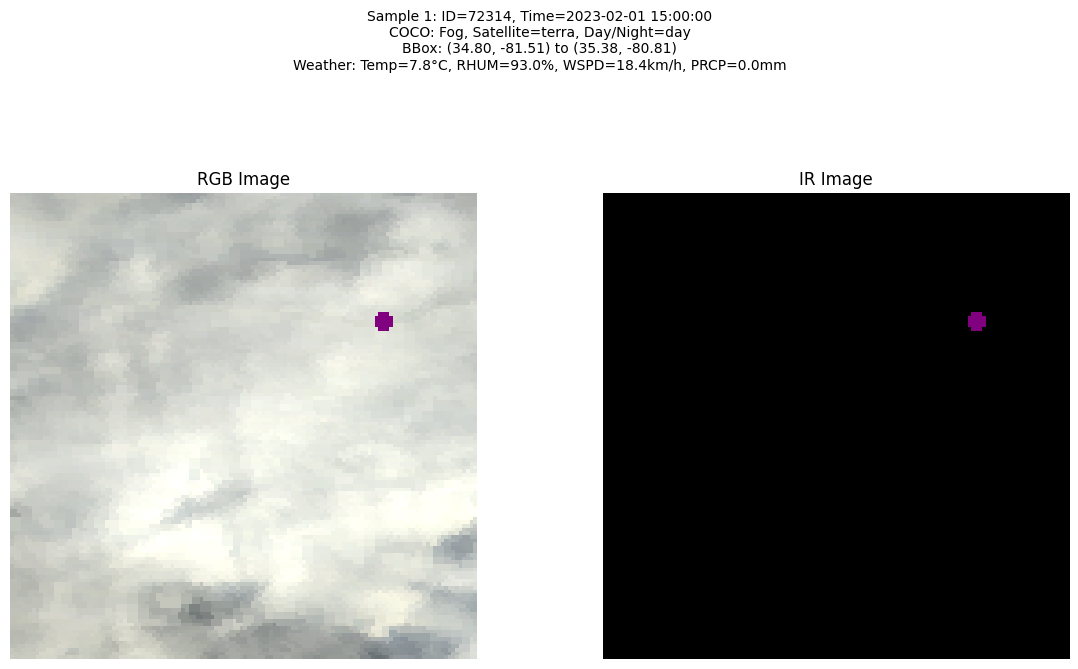

dict_keys(['id', 'time', 'lat', 'lon', 'coco', 'local_hour', 'temp', 'dwpt', 'rhum', 'prcp', 'snow', 'wdir', 'wspd', 'wpgt', 'pres', 'tsun', 'filename', 'satellite', 'day_night', 'utc_yymmddhh', 'local_hour_filename', 'bbox_lat1', 'bbox_lon1', 'bbox_lat2', 'bbox_lon2'])


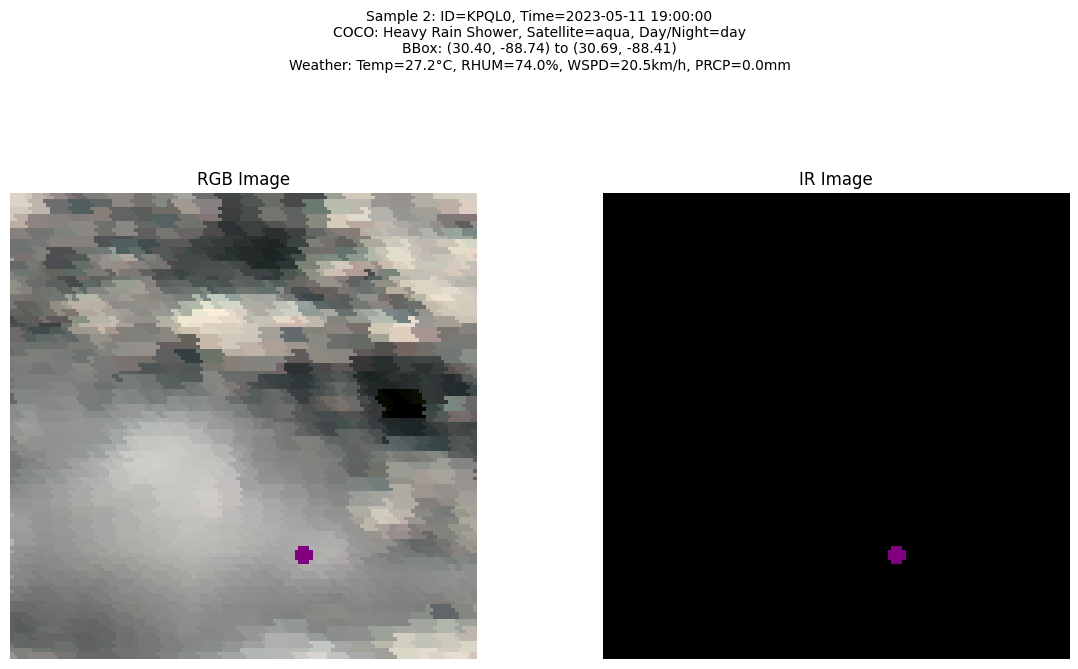

dict_keys(['id', 'time', 'lat', 'lon', 'coco', 'local_hour', 'temp', 'dwpt', 'rhum', 'prcp', 'snow', 'wdir', 'wspd', 'wpgt', 'pres', 'tsun', 'filename', 'satellite', 'day_night', 'utc_yymmddhh', 'local_hour_filename', 'bbox_lat1', 'bbox_lon1', 'bbox_lat2', 'bbox_lon2'])


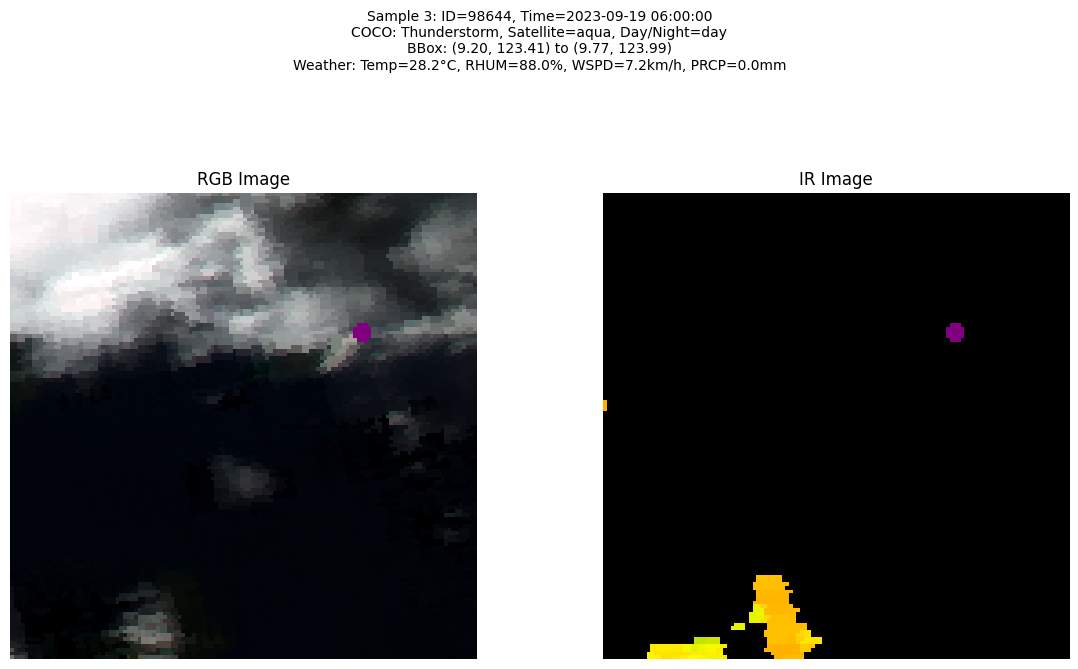

In [2]:
import pandas as pd
import os
import re
from PIL import Image, ImageDraw
from typing import Tuple, Dict, Optional, List
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# --- 1. 사용자 설정 ---
csv_loc = 'gee_weather_ground_truth_balanced.csv'
ir_img_loc = './ir'
rgb_img_loc = './rgb'

# --- 2. 헬퍼 함수 정의 ---

# COCO 맵: 'coco' 숫자 값에 대한 텍스트 설명
# 참고: 이 맵은 예시입니다. 'balanced' 데이터셋의 실제 클래스 레이블에 맞게 수정해주세요.
COCO_MAP = {
    1: 'Clear',
    2: 'Fair',
    3: 'Cloudy',
    4: 'Overcast',
    5: 'Fog',
    6: 'Freezing Fog',
    7: 'Light Rain',
    8: 'Rain',
    9: 'Heavy Rain',
    10: 'Freezing Rain',
    11: 'Heavy Freezing Rain',
    12: 'Sleet',
    13: 'Heavy Sleet',
    14: 'Light Snowfall',
    15: 'Snowfall',
    16: 'Heavy Snowfall',
    17: 'Rain Shower',
    18: 'Heavy Rain Shower',
    19: 'Sleet Shower',
    20: 'Heavy Sleet Shower',
    21: 'Snow Shower',
    22: 'Heavy Snow Shower',
    23: 'Lightning',
    24: 'Hail',
    25: 'Thunderstorm',
    26: 'Heavy Thunderstorm',
    27: 'Storm',
}


def parse_filename_for_matching(filename: str) -> Optional[Dict]:
    """
    이미지 파일명에서 매칭에 필요한 ID, COCO, UTC 시간을 추출합니다.
    filename 예시: 5IQAF_terra_day_coco14_23021420_lh10_59.573466_-157.095593_64.186078_-147.309078.png
    """
    pattern = r'([^_]+)_([^_]+)_(day|night)_coco(\d+)_(\d{8})_lh(\d+)_.*\.png'
    match = re.match(pattern, filename)
    if match:
        # 파일명에서 YYYYMMDDHH 부분을 추출
        # (앞 두자리는 연도, 뒤 두자리는 시간으로 가정)
        yymmddhh_str = match.group(5)
        
        # UTC 시간을 고려하기 위해, 파일명에서 추출한 HH는 local_hour가 아닌 UTC 시간으로 간주
        # 즉, 23021420에서 20은 local_hour가 아니라 UTC 시간 20시를 의미
        # 이를 CSV의 'time' 컬럼 (YYYY-MM-DD HH:MM:SS+00:00)과 매칭하기 위함.
        
        return {
            'id': match.group(1),
            'coco': int(match.group(4)),
            'utc_datetime_str': yymmddhh_str # 예: '23021420'
        }
    return None

def find_file(directory: str, id_prefix: str, coco_str: str, utc_datetime_str: str) -> Optional[str]:
    """
    디렉토리에서 특정 ID, COCO, UTC 시간 패턴을 가진 파일을 찾습니다.
    local_hour를 파일명에 포함하지 않으므로, 이 부분을 와일드카드로 처리합니다.
    """
    if not os.path.exists(directory):
        return None
    
    # regex 패턴을 사용하여 유연하게 검색
    # id_prefix, satellite, day_night, coco, utc_datetime, local_hour(와일드카드), bbox 정보
    # 예: "5IQAF_terra_day_coco14_23021420_lh(\d+)_.*\.png"
    search_pattern = re.compile(rf"^{re.escape(id_prefix)}_([^_]+)_(day|night)_coco{re.escape(coco_str)}_{re.escape(utc_datetime_str)}_lh(\d{{2}})_.*\.png$")

    for f in os.listdir(directory):
        if search_pattern.match(f):
            return os.path.join(directory, f)
    return None


def parse_full_filename_metadata(filename: str) -> Dict:
    """
    파일 이름의 모든 메타데이터를 파싱하여 딕셔너리로 반환합니다.
    """
    metadata = {}
    pattern = r'([^_]+)_([^_]+)_(day|night)_coco(\d+)_(\d{8})_lh(\d+)_([-\d.]+)_([-\d.]+)_([-\d.]+)_([-\d.]+)\.png'
    match = re.match(pattern, filename)
    if match:
        metadata['filename'] = filename
        metadata['id'] = match.group(1)
        metadata['satellite'] = match.group(2)
        metadata['day_night'] = match.group(3)
        metadata['coco'] = int(match.group(4))
        metadata['utc_yymmddhh'] = match.group(5) # 파일명에서 추출된 YYYYMMDDHH
        metadata['local_hour_filename'] = int(match.group(6)) # 파일명에 있는 local hour 정보
        metadata['bbox_lat1'] = float(match.group(7))
        metadata['bbox_lon1'] = float(match.group(8))
        metadata['bbox_lat2'] = float(match.group(9))
        metadata['bbox_lon2'] = float(match.group(10))
    return metadata

def calculate_dot_position(metadata: Dict) -> Tuple[Optional[float], Optional[float], bool]:
    """
    메타데이터(CSV의 lat/lon 및 파일명의 bbox)를 기반으로
    128x128 이미지 상의 점의 (x, y) 픽셀 위치를 계산합니다.
    """
    dot_keys = ['lat', 'lon', 'bbox_lat1', 'bbox_lon1', 'bbox_lat2', 'bbox_lon2']
    # 모든 키가 메타데이터에 있는지 확인
    if not all(key in metadata for key in dot_keys):
        return None, None, False

    try:
        # CSV에서 가져온 lat/lon (관측소 위치)
        lat_target = float(metadata['lat'])
        lon_target = float(metadata['lon'])
        # 파일명에서 파싱한 Bounding Box (이미지 범위)
        lat_min = float(metadata['bbox_lat1']) # 남쪽
        lon_min = float(metadata['bbox_lon1']) # 서쪽
        lat_max = float(metadata['bbox_lat2']) # 북쪽
        lon_max = float(metadata['bbox_lon2']) # 동쪽

        # 이미지 픽셀 크기 (0-127)
        img_width = 128
        img_height = 128
        
        # BBox 크기가 0인 경우 (오류 방지)
        if (lon_max - lon_min) == 0 or (lat_max - lat_min) == 0:
            return None, None, False
        else:
            # X 좌표 계산 (경도 -> 픽셀 X)
            lon_percent = (lon_target - lon_min) / (lon_max - lon_min)
            pixel_x = lon_percent * (img_width - 1)
            
            # Y 좌표 계산 (위도 -> 픽셀 Y)
            lat_percent_from_top = (lat_max - lat_target) / (lat_max - lat_min)
            pixel_y = lat_percent_from_top * (img_height - 1)

            # 점이 이미지 범위(0-127) 내에 있는지 확인
            if not (0 <= pixel_x < img_width and 0 <= pixel_y < img_height):
                return None, None, False # Out of bounds
            
            return pixel_x, pixel_y, True

    except (ValueError, TypeError, ZeroDivisionError):
        # 좌표 데이터가 유효하지 않은 경우
        return None, None, False

def get_available_records_optimized(csv_path: str, rgb_dir: str, ir_dir: str) -> pd.DataFrame:
    """
    최적화된 버전: 이미지 파일명을 파싱하여 DataFrame으로 만든 후,
    메인 CSV와 Merge(Inner Join)하여 교집합을 빠르게 찾습니다.
    이제 local_hour는 사용하지 않고 UTC 시간을 기준으로 매칭합니다.
    """
    # 1. 이미지 파일 목록 수집 및 파싱
    rgb_files = set(os.listdir(rgb_dir)) if os.path.exists(rgb_dir) else set()
    ir_files = set(os.listdir(ir_dir)) if os.path.exists(ir_dir) else set()
    all_files = list(rgb_files)

    print(f"총 {len(all_files)}개의 이미지 파일을 찾았습니다.")

    img_metadata = []
    for filename in all_files:
        parsed_data = parse_filename_for_matching(filename)
        if parsed_data:
            img_metadata.append(parsed_data)
    
    img_df = pd.DataFrame(img_metadata)
    img_df = img_df.drop_duplicates() # RGB와 IR이 같은 이름을 가질 수 있으므로 중복 제거

    if img_df.empty:
        print("경고: 매칭 가능한 이미지 파일 메타데이터를 찾을 수 없습니다.")
        return pd.DataFrame()

    print(f"파싱된 고유 이미지 메타데이터 수: {len(img_df)}")

    # 2. 대용량 CSV 로드
    print("CSV 파일 로드 중...")
    df = pd.read_csv(csv_path)
    
    # 3. CSV 데이터 전처리 (UTC 시간 기준으로 매칭 키 생성)
    print("CSV 데이터 전처리 중 (UTC 시간 기준)...")
    # 'time' 컬럼을 UTC datetime 객체로 변환
    df['time_utc_dt'] = pd.to_datetime(df['time'], utc=True)
    # 이미지 파일명 형식과 일치하도록 'YYMMDDHH' 형식의 UTC 문자열 생성
    df['utc_datetime_str'] = df['time_utc_dt'].dt.strftime('%y%m%d%H')
    
    # 4. Merge를 통한 고속 필터링 (Inner Join)
    # CSV(Left)와 이미지목록(Right)을 교집합으로 병합
    print("이미지 메타데이터와 CSV 데이터 병합 중...")
    merged_df = pd.merge(
        df, 
        img_df, 
        on=['id', 'coco', 'utc_datetime_str'], # 'local_hour' 대신 'utc_datetime_str' 사용
        how='inner'
    )
    
    # 임시 컬럼 제거 및 'id'와 'time' 기준으로 중복 제거 (여러 이미지 파일이 동일한 CSV 레코드에 매칭될 수 있으므로)
    final_df = merged_df.drop(columns=['utc_datetime_str', 'time_utc_dt']).drop_duplicates(subset=['id', 'time'])
    
    print(f"최종 매칭된 레코드 수: {len(final_df)}")
    return final_df.reset_index(drop=True)


def extract_data(csv_path: str, rgb_dir: str, ir_dir: str, n: int = 1, visualize_dot: bool = False) -> List[Tuple[Optional[Image.Image], Optional[Image.Image], Dict]]:
    """
    메타데이터와 이미지를 함께 추출합니다.
    visualize_dot=True일 경우, 이미지에 직접 빨간 점을 오버레이합니다.
    """
    available_df = get_available_records_optimized(csv_path, rgb_dir, ir_dir)
    
    if len(available_df) == 0:
        print("Warning: 이미지가 존재하는 레코드가 없습니다.")
        return []
    
    # 샘플링
    n = min(n, len(available_df))
    sampled_df = available_df.sample(n=n, random_state=42) # 재현성을 위해 random_state 추가
    
    results = []
    
    print(f"\n{n}개의 샘플 이미지 추출 중...")
    for idx, row in sampled_df.iterrows():
        metadata = row.to_dict()
        
        # CSV의 time 컬럼을 UTC datetime으로 변환 후 'YYMMDDHH' 형식으로 파일 검색 키 생성
        time_utc_dt = pd.to_datetime(row['time'], utc=True)
        utc_datetime_for_filename = time_utc_dt.strftime('%y%m%d%H')
        
        id_prefix = row['id']
        coco_str = str(row['coco'])
        
        rgb_image = None
        ir_image = None
        
        # 점 그리기 관련 변수 초기화
        pixel_x, pixel_y, can_plot_dot = None, None, False
        
        # 파일 검색 (local_hour 대신 UTC 시간을 사용하도록 find_file 함수 수정)
        rgb_path = find_file(rgb_dir, id_prefix, coco_str, utc_datetime_for_filename)
        ir_path = find_file(ir_dir, id_prefix, coco_str, utc_datetime_for_filename)
        
        if rgb_path:
            try:
                rgb_image = Image.open(rgb_path)
                # 파일명에서 추가 메타데이터 파싱 및 업데이트
                metadata.update(parse_full_filename_metadata(os.path.basename(rgb_path)))
                
                # --- [수정된 부분] ---
                if visualize_dot:
                    # 점 위치 계산
                    (pixel_x, pixel_y, can_plot_dot) = calculate_dot_position(metadata)
                    if can_plot_dot and rgb_image:
                        try:
                            # 점을 그리기 위해 RGB 모드로 변환
                            rgb_image = rgb_image.convert("RGB")
                            draw = ImageDraw.Draw(rgb_image)
                            # 5x5 크기 (반지름 2)의 빨간 원 그리기
                            draw.ellipse((pixel_x - 2, pixel_y - 2, pixel_x + 2, pixel_y + 2), fill='purple', outline='purple')
                        except Exception as e:
                            print(f"Warning: RGB 이미지에 점을 그리는 중 오류: {e}")
                # --- [수정 완료] ---
                            
            except Exception as e:
                print(f"Warning: RGB 이미지 로드 또는 파싱 실패 ({rgb_path}): {e}")
                rgb_image = None # 오류 시 None으로 설정
                
        if ir_path:
            try:
                ir_image = Image.open(ir_path)
                # RGB 이미지가 없어 메타데이터가 업데이트되지 않았다면 IR 파일에서 파싱하여 업데이트
                if 'satellite' not in metadata: 
                    metadata.update(parse_full_filename_metadata(os.path.basename(ir_path)))
                
                # --- [수정된 부분] ---
                if visualize_dot:
                    # RGB 처리 시 점 위치가 계산되지 않았다면 재계산
                    if not can_plot_dot:
                         (pixel_x, pixel_y, can_plot_dot) = calculate_dot_position(metadata)
                    
                    if can_plot_dot and ir_image:
                        try:
                            # 점을 그리기 위해 RGB 모드로 변환 (컬러맵이 적용된 IR 이미지이므로)
                            ir_image = ir_image.convert("RGB")
                            draw = ImageDraw.Draw(ir_image)
                            draw.ellipse((pixel_x - 2, pixel_y - 2, pixel_x + 2, pixel_y + 2), fill='purple', outline='purple')
                        except Exception as e:
                            print(f"Warning: IR 이미지에 점을 그리는 중 오류: {e}")
                # --- [수정 완료] ---
                            
            except Exception as e:
                print(f"Warning: IR 이미지 로드 또는 파싱 실패 ({ir_path}): {e}")
                ir_image = None # 오류 시 None으로 설정

        if rgb_image or ir_image: # 둘 중 하나라도 성공적으로 로드된 경우에만 추가
            results.append((rgb_image, ir_image, metadata))
        else:
            print(f"Warning: {row['id']} ({row['time']}) 에 대한 RGB, IR 이미지 모두 로드 실패. 건너뜜.")
            
    return results

# --- 3. 실행 및 시각화 ---

# 샘플 추출
# visualize_dot=True로 설정하여 이미지에 점을 그리도록 함
sampled_data = extract_data(csv_loc, rgb_img_loc, ir_img_loc, n=3, visualize_dot=True)

print(f"\n총 {len(sampled_data)}개의 샘플을 시각화합니다.")

# Matplotlib을 사용하여 시각화
for i, (rgb_img, ir_img, metadata) in enumerate(sampled_data):
    print(metadata.keys())
    fig, axes = plt.subplots(1, 2, figsize=(12, 7))
    
    weather_info = (
        f"Weather: Temp={metadata.get('temp', 'N/A')}°C, "
        f"RHUM={metadata.get('rhum', 'N/A')}%, "
        f"WSPD={metadata.get('wspd', 'N/A')}km/h, "
        f"PRCP={metadata.get('prcp', 'N/A')}mm"
    )

    # --- [수정된 부분] COCO 텍스트 매핑 ---
    coco_val = metadata.get('coco')
    # COCO_MAP에서 텍스트를 찾고, 없으면 f"Unknown Class ({coco_val})" 반환
    coco_text = COCO_MAP.get(coco_val, f"Unknown Class ({coco_val})")
    
    fig.suptitle(f"Sample {i+1}: ID={metadata.get('id', 'N/A')}, Time={metadata.get('time', 'N/A')}\n"
                 f"COCO: {coco_text}, Satellite={metadata.get('satellite', 'N/A')}, "
                 f"Day/Night={metadata.get('day_night', 'N/A')}\n"
                 f"BBox: ({metadata.get('bbox_lat1', 'N/A'):.2f}, {metadata.get('bbox_lon1', 'N/A'):.2f}) "
                 f"to ({metadata.get('bbox_lat2', 'N/A'):.2f}, {metadata.get('bbox_lon2', 'N/A'):.2f})\n"
                 f"{weather_info}",
                 fontsize=10)
    # --- [수정 완료] ---

    # --- [수정된 부분] 점 위치 계산 로직 제거 ---
    # (extract_data 함수 내부로 이동됨)
    # --- [수정 완료] ---

    # RGB 이미지 표시
    if rgb_img:
        axes[0].imshow(rgb_img)
        axes[0].set_title("RGB Image")
        axes[0].axis('off')
        # --- [수정된 부분] Matplotlib의 plot 호출 제거 ---
        # (이미지에 점이 그려져 있음)
        # --- [수정 완료] ---
    else:
        axes[0].text(0.5, 0.5, "RGB Image Not Available", horizontalalignment='center', verticalalignment='center', transform=axes[0].transAxes)
        axes[0].set_title("RGB Image (N/A)")
        axes[0].axis('off')

    # IR 이미지 표시
    if ir_img:
        axes[1].imshow(ir_img)
        axes[1].set_title("IR Image")
        axes[1].axis('off')
        # --- [수정된 부분] Matplotlib의 plot 호출 제거 ---
        # (이미지에 점이 그려져 있음)
        # --- [수정 완료] ---
    else:
        axes[1].text(0.5, 0.5, "IR Image Not Available", horizontalalignment='center', verticalalignment='center', transform=axes[1].transAxes)
        axes[1].set_title("IR Image (N/A)")
        axes[1].axis('off')
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.85]) # 제목과 겹치지 않도록 상단 여백 조절 (0.88 -> 0.85)
    plt.show()

# 추가로, 매칭된 데이터프레임을 확인하고 싶다면:
# final_matched_df = get_available_records_optimized(csv_loc, rgb_img_loc, ir_img_loc)
# print("\n매칭된 최종 데이터프레임 헤드:")
# print(final_matched_df.head())

In [ ]:
import os
import json
import logging
import time
import asyncio
from concurrent.futures import ThreadPoolExecutor
import google.generativeai as genai
from google.generativeai.types import GenerationConfig, HarmCategory, HarmBlockThreshold
from google.api_core.exceptions import ResourceExhausted, InternalServerError

from PIL import Image, ImageDraw, ImageFont
from tqdm.asyncio import tqdm as async_tqdm
from typing import List, Tuple, Optional, Dict, Any, Set
from dotenv import load_dotenv

# 1. 설정 및 데이터 로더 임포트
from qagen_conf import COCO_MAP, SYSTEM_PROMPT, GENERATION_THEMES

# 2. 로깅 설정
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# --- (사용자 설정 변수) ---
DATA_CSV = "./gee_weather_ground_truth_balanced.csv"  # (필수) CSV 파일 경로
RGB_DIR = "./rgb/"                 # (필수) RGB 이미지 디렉터리
IR_DIR = "./ir/"                   # (필수) LST(IR) 이미지 디렉터리
NUM_SAMPLES = 20                   # (필수) 처리할 샘플 수
OUTPUT_FILE = "generated_weather_dataset_gemini_pureeval.jsonl"
OUTPUT_FILE_PREV = "generated_weather_dataset_gemini.jsonl"

# Gemini API Tier 1 설정 (RPM: 15, TPM: 1M)
MAX_CONCURRENT_REQUESTS = 5  # 동시 실행 가능한 최대 요청 수
REQUESTS_PER_MINUTE = 10      # 분당 최대 요청 수
# ------------------------------

# --- (Gemini API 설정) ---
load_dotenv()  # .env 파일에서 환경 변수 로드
GEMINI_API_KEY = os.getenv("GEMINI_API_KEY")
if not GEMINI_API_KEY:
    raise ValueError("GEMINI_API_KEY가 .env 파일에 설정되지 않았습니다.")

genai.configure(api_key=GEMINI_API_KEY)
GEMINI_MODEL_NAME = "gemini-2.5-flash-preview-09-2025"
# ------------------------------

af
def load_existing_filenames(jsonl_path: str) -> Set[str]:
    """
    기존 JSONL 파일에서 이미 처리된 source_filename을 hash table(set)로 로드합니다.
    """
    existing_files = set()
    if not os.path.exists(jsonl_path):
        logging.info(f"{jsonl_path} 파일이 없습니다. 처음부터 시작합니다.")
        return existing_files
    
    try:
        with open(jsonl_path, 'r', encoding='utf-8') as f:
            for line in f:
                if line.strip():
                    try:
                        entry = json.loads(line)
                        source_filename = entry.get('source_filename')
                        if source_filename:
                            existing_files.add(source_filename)
                    except json.JSONDecodeError:
                        continue
        logging.info(f"기존 JSONL에서 {len(existing_files)}개의 처리된 레코드를 로드했습니다.")
    except Exception as e:
        logging.error(f"기존 JSONL 파일 로드 중 오류: {e}")
    
    return existing_files


def stitch_images(rgb_img: Image.Image, ir_img: Image.Image) -> Image.Image:
    """RGB와 IR 이미지를 좌우로 이어붙여 하나의 이미지로 만듭니다."""
    h = min(rgb_img.height, ir_img.height)
    rgb_img = rgb_img.resize((int(rgb_img.width * h / rgb_img.height), h))
    ir_img = ir_img.resize((int(ir_img.width * h / ir_img.height), h))
    total_width = rgb_img.width + ir_img.width
    combined_img = Image.new('RGB', (total_width, h))
    combined_img.paste(rgb_img, (0, 0))
    combined_img.paste(ir_img, (rgb_img.width, 0))
    try:
        draw = ImageDraw.Draw(combined_img)
        font = ImageFont.load_default()
        draw.text((10, 10), "RGB", fill="white", font=font)
        draw.text((rgb_img.width + 10, 10), "LST/IR", fill="white", font=font)
    except Exception:
        pass
    return combined_img


def clean_json_output_all_themes(raw_text: str) -> Optional[List[Dict[str, str]]]:
    """
    Gemini의 JSON 출력 문자열을 파싱합니다 (모든 테마의 Q/A 배열).
    """
    try:
        if "```json" in raw_text:
            raw_text = raw_text.split("```json")[1].split("```")[0].strip()
        
        parsed_json = json.loads(raw_text)
        
        # 배열 형식 확인
        if isinstance(parsed_json, list):
            # 각 항목이 question, answer, theme을 가지고 있는지 확인
            valid_qas = []
            for qa in parsed_json:
                if isinstance(qa, dict) and "question" in qa and "answer" in qa and "theme" in qa:
                    valid_qas.append(qa)
            
            if valid_qas:
                return valid_qas
            else:
                logging.warning(f"유효한 Q/A 항목이 없음: {raw_text[:200]}")
                return None
        else:
            logging.warning(f"JSON이 배열 형식이 아님: {raw_text[:200]}")
            return None
            
    except json.JSONDecodeError as e:
        logging.error(f"JSON 디코딩 실패: {e}\nRaw text: {raw_text[:500]}")
        return None
    except Exception as e:
        logging.error(f"JSON 정리 중 알 수 없는 오류: {e}")
        return None


async def run_gemini_generation_all_themes_async(
    model: genai.GenerativeModel,
    combined_image: Image.Image,
    labels: Dict[str, Any],
    semaphore: asyncio.Semaphore,
    rate_limiter: asyncio.Semaphore,
    max_retries: int = 5
) -> Optional[List[Dict[str, str]]]:
    """
    비동기로 Gemini API를 호출하여 모든 테마의 Q/A를 한 번에 생성합니다.
    반환: List[qa_pair] 또는 None
    """
    
    # 1. 라벨을 JSON 문자열로 변환
    labels_to_serialize = {k: v for k, v in labels.items() if isinstance(v, (str, int, float, bool))}
    try:
        coco_code = int(labels_to_serialize.get('coco', 0))
        if coco_code in COCO_MAP:
            labels_to_serialize['coco_description'] = COCO_MAP[coco_code]
    except Exception:
        pass
    labels_json_str = json.dumps(labels_to_serialize, indent=2)

    # 2. 모든 테마를 하나의 프롬프트로 구성
    themes_text = "\n\n".join([
        f"Theme {i}: {theme_name}\n{theme_prompt}"
        for i, (theme_name, theme_prompt) in enumerate(GENERATION_THEMES.items())
    ])
    
    user_prompt_text = f"""Ground Truth Labels (Secret):
{labels_json_str}

Generation Themes (Generate one Q/A pair for EACH theme):
{themes_text}

IMPORTANT: Generate a JSON array with {len(GENERATION_THEMES)} objects. Each object MUST have:
- "theme": the theme name (e.g., "Theme 0: Basic Observation")
- "question": the generated question
- "answer": the generated answer

Example format:
[
  {{"theme": "Theme 0: Basic Observation", "question": "...", "answer": "..."}},
  {{"theme": "Theme 1: Holistic Analysis", "question": "...", "answer": "..."}},
  ...
]
"""
    
    # 3. API 호출 (지수 백오프 포함)
    retry_delay = 2
    
    async with semaphore:  # 동시 실행 제한
        for attempt in range(max_retries):
            try:
                # RPM 제한 관리
                async with rate_limiter:
                    # ThreadPoolExecutor를 사용하여 동기 API를 비동기로 실행
                    loop = asyncio.get_event_loop()
                    response = await loop.run_in_executor(
                        None,
                        lambda: model.generate_content([combined_image, user_prompt_text])
                    )
                
                # 응답 텍스트 추출 및 JSON 파싱
                raw_text = response.text
                qa_list = clean_json_output_all_themes(raw_text)
                
                if qa_list and len(qa_list) > 0:
                    return qa_list
                else:
                    logging.warning(f"ID {labels.get('id', 'N/A')}: 유효한 Q/A를 생성하지 못했습니다. 재시도...")
                    await asyncio.sleep(retry_delay)
                    retry_delay *= 2

            except (ResourceExhausted, InternalServerError) as e:
                logging.warning(f"API 오류 (ID: {labels.get('id', 'N/A')}): {e}. {retry_delay}초 후 재시도... (시도 {attempt + 1}/{max_retries})")
                await asyncio.sleep(retry_delay)
                retry_delay *= 2
            except Exception as e:
                if hasattr(e, 'response') and hasattr(e.response, 'prompt_feedback'):
                    logging.error(f"API 호출 실패 (Prompt Feedback, ID: {labels.get('id', 'N/A')}): {e.response.prompt_feedback}")
                else:
                    logging.error(f"Gemini 생성 중 오류 (ID: {labels.get('id', 'N/A')}): {e}")
                return None
                
    logging.error(f"최대 재시도({max_retries}회) 실패 (ID: {labels.get('id', 'N/A')}). 건너뜁니다.")
    return None


async def process_single_sample(
    model: genai.GenerativeModel,
    rgb_img: Image.Image,
    ir_img: Image.Image,
    labels: Dict[str, Any],
    semaphore: asyncio.Semaphore,
    rate_limiter: asyncio.Semaphore,
    existing_filenames: Set[str],
    output_file: str,
    file_lock: asyncio.Lock
) -> bool:
    """단일 샘플에 대해 모든 테마의 Q/A를 한 번의 API 호출로 생성하고 즉시 파일에 저장합니다."""
    
    source_filename = labels.get('filename', 'N/A')
    
    # 이미 처리된 파일인지 확인
    if source_filename in existing_filenames:
        logging.info(f"스킵: {source_filename} (이미 처리됨)")
        return False
    
    if rgb_img is None or ir_img is None:
        logging.warning(f"ID {labels.get('id', 'N/A')}의 이미지가 없어 건너뜁니다.")
        return False
    
    try:
        combined_img = stitch_images(rgb_img, ir_img)
    except Exception as e:
        logging.error(f"ID {labels.get('id', 'N/A')} 이미지 합성 중 오류: {e}")
        return False
    
    # 모든 테마에 대한 Q/A를 한 번에 생성
    generated_qas = await run_gemini_generation_all_themes_async(
        model, combined_img, labels, semaphore, rate_limiter
    )
    
    if not generated_qas:
        logging.warning(f"ID {labels.get('id', 'N/A')} - Q/A 생성 실패")
        return False
    
    final_entry = {
        "sample_id": labels.get('id', 'N/A'),
        "source_filename": source_filename,
        "ground_truth_labels": {k: v for k, v in labels.items() if isinstance(v, (str, int, float, bool))},
        "generated_qas": generated_qas
    }
    
    # 즉시 파일에 저장 (파일 락 사용)
    async with file_lock:
        try:
            with open(output_file, 'a', encoding='utf-8') as f:
                f.write(json.dumps(final_entry, ensure_ascii=False) + '\n')
            existing_filenames.add(source_filename)  # 메모리 캐시 업데이트
            logging.info(f"저장 완료: {source_filename}")
            return True
        except Exception as e:
            logging.error(f"파일 저장 실패 ({source_filename}): {e}")
            return False


class RateLimiter:
    """RPM 제한을 관리하는 Rate Limiter"""
    def __init__(self, requests_per_minute: int):
        self.requests_per_minute = requests_per_minute
        self.min_interval = 60.0 / requests_per_minute
        self.last_request_time = 0
        self.lock = asyncio.Lock()
    
    async def acquire(self):
        async with self.lock:
            current_time = time.time()
            elapsed = current_time - self.last_request_time
            
            if elapsed < self.min_interval:
                wait_time = self.min_interval - elapsed
                await asyncio.sleep(wait_time)
            
            self.last_request_time = time.time()


async def main_async():
    """비동기 메인 데이터셋 생성 파이프라인"""
    
    logging.info("Gemini API로 비동기 병렬 데이터 생성 파이프라인 시작...")
    
    # 0. 기존 처리된 파일명 로드
    existing_filenames = load_existing_filenames(OUTPUT_FILE_PREV)
    
    # 1. Gemini 모델 설정 (모든 테마를 한 번에 처리하므로 배열 스키마 사용)
    json_schema = {
        "type": "ARRAY",
        "items": {
            "type": "OBJECT",
            "properties": {
                "theme": {"type": "STRING"},
                "question": {"type": "STRING"},
                "answer": {"type": "STRING"},
            },
            "required": ["theme", "question", "answer"],
        }
    }
    
    generation_config = GenerationConfig(
        response_mime_type="application/json",
        response_schema=json_schema,
        temperature=0.7,
        max_output_tokens=8192,  # 모든 테마를 한 번에 생성하므로 증가
    )

    safety_settings = {
        HarmCategory.HARM_CATEGORY_HATE_SPEECH: HarmBlockThreshold.BLOCK_NONE,
        HarmCategory.HARM_CATEGORY_HARASSMENT: HarmBlockThreshold.BLOCK_NONE,
        HarmCategory.HARM_CATEGORY_SEXUALLY_EXPLICIT: HarmBlockThreshold.BLOCK_NONE,
        HarmCategory.HARM_CATEGORY_DANGEROUS_CONTENT: HarmBlockThreshold.BLOCK_NONE,
    }

    try:
        model = genai.GenerativeModel(
            model_name=GEMINI_MODEL_NAME,
            system_instruction=SYSTEM_PROMPT,
            generation_config=generation_config,
            safety_settings=safety_settings
        )
    except Exception as e:
        logging.error(f"Gemini 모델 초기화 실패: {e}")
        return

    logging.info(f"{GEMINI_MODEL_NAME} 모델 초기화 완료 (JSON 모드, 배열 스키마, max_tokens=8192).")
    
    # 2. 데이터 로드
    logging.info("데이터 로드 중...")
    all_data = extract_data(DATA_CSV, RGB_DIR, IR_DIR, n=NUM_SAMPLES)
    
    if not all_data:
        logging.error("로드된 데이터가 없습니다. CSV 및 디렉터리 경로를 확인하세요.")
        return

    # 이미 처리된 데이터 필터링
    filtered_data = [
        (rgb_img, ir_img, labels) 
        for rgb_img, ir_img, labels in all_data 
        if labels.get('filename', 'N/A') not in existing_filenames
    ]
    
    if not filtered_data:
        logging.info("모든 샘플이 이미 처리되었습니다.")
        return
    
    logging.info(f"총 {len(all_data)}개 중 {len(filtered_data)}개의 미처리 샘플을 처리합니다.")
    
    # 3. 세마포어 및 Rate Limiter 설정
    semaphore = asyncio.Semaphore(MAX_CONCURRENT_REQUESTS)
    rate_limiter = RateLimiter(REQUESTS_PER_MINUTE)
    file_lock = asyncio.Lock()  # 파일 쓰기 동기화를 위한 락
    
    # Rate limiter를 Semaphore로 래핑
    class RateLimiterSemaphore:
        def __init__(self, limiter):
            self.limiter = limiter
        
        async def __aenter__(self):
            await self.limiter.acquire()
        
        async def __aexit__(self, *args):
            pass
    
    rate_limiter_sem = RateLimiterSemaphore(rate_limiter)
    
    # 4. 모든 샘플 병렬 처리 (각 샘플은 완료 즉시 파일에 저장됨)
    tasks = [
        process_single_sample(model, rgb_img, ir_img, labels, semaphore, rate_limiter_sem, 
                            existing_filenames, OUTPUT_FILE, file_lock)
        for rgb_img, ir_img, labels in filtered_data
    ]
    
    # tqdm으로 진행상황 표시
    success_count = 0
    for coro in async_tqdm(asyncio.as_completed(tasks), total=len(tasks), desc="Processing Samples"):
        result = await coro
        if result:
            success_count += 1
    
    # 5. 최종 결과 요약
    logging.info(f"처리 완료: {success_count}개의 새로운 레코드가 {OUTPUT_FILE}에 저장되었습니다.")


def main():
    """메인 함수 - 비동기 실행 래퍼"""
    # Jupyter 환경에서 이미 이벤트 루프가 실행 중일 수 있으므로 처리
    try:
        loop = asyncio.get_event_loop()
        if loop.is_running():
            # Jupyter/IPython 환경
            import nest_asyncio
            nest_asyncio.apply()
            loop.run_until_complete(main_async())
        else:
            # 일반 Python 환경
            asyncio.run(main_async())
    except RuntimeError:
        # 새로운 이벤트 루프 생성
        asyncio.run(main_async())


if __name__ == "__main__":
    main()

2025-11-19 22:27:31,085 - INFO - Gemini API로 비동기 병렬 데이터 생성 파이프라인 시작...


2025-11-19 22:27:31,120 - INFO - 기존 JSONL에서 1071개의 처리된 레코드를 로드했습니다.
2025-11-19 22:27:31,122 - INFO - gemini-2.5-flash-preview-09-2025 모델 초기화 완료 (JSON 모드, 배열 스키마, max_tokens=8192).
2025-11-19 22:27:31,122 - INFO - 데이터 로드 중...


총 10552개의 이미지 파일을 찾았습니다.
파싱된 고유 이미지 메타데이터 수: 10552
CSV 파일 로드 중...
CSV 데이터 전처리 중 (UTC 시간 기준)...
이미지 메타데이터와 CSV 데이터 병합 중...
최종 매칭된 레코드 수: 10552

20개의 샘플 이미지 추출 중...


2025-11-19 22:27:33,935 - INFO - 총 20개 중 18개의 미처리 샘플을 처리합니다.
Processing Samples: 100%|██████████| 18/18 [02:00<00:00,  6.69s/it]
2025-11-19 22:29:34,331 - INFO - 처리 완료: 18개의 새로운 레코드가 generated_weather_dataset_gemini_pureeval.jsonl에 저장되었습니다.


/tmp/ipykernel_3938328/2056702789.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


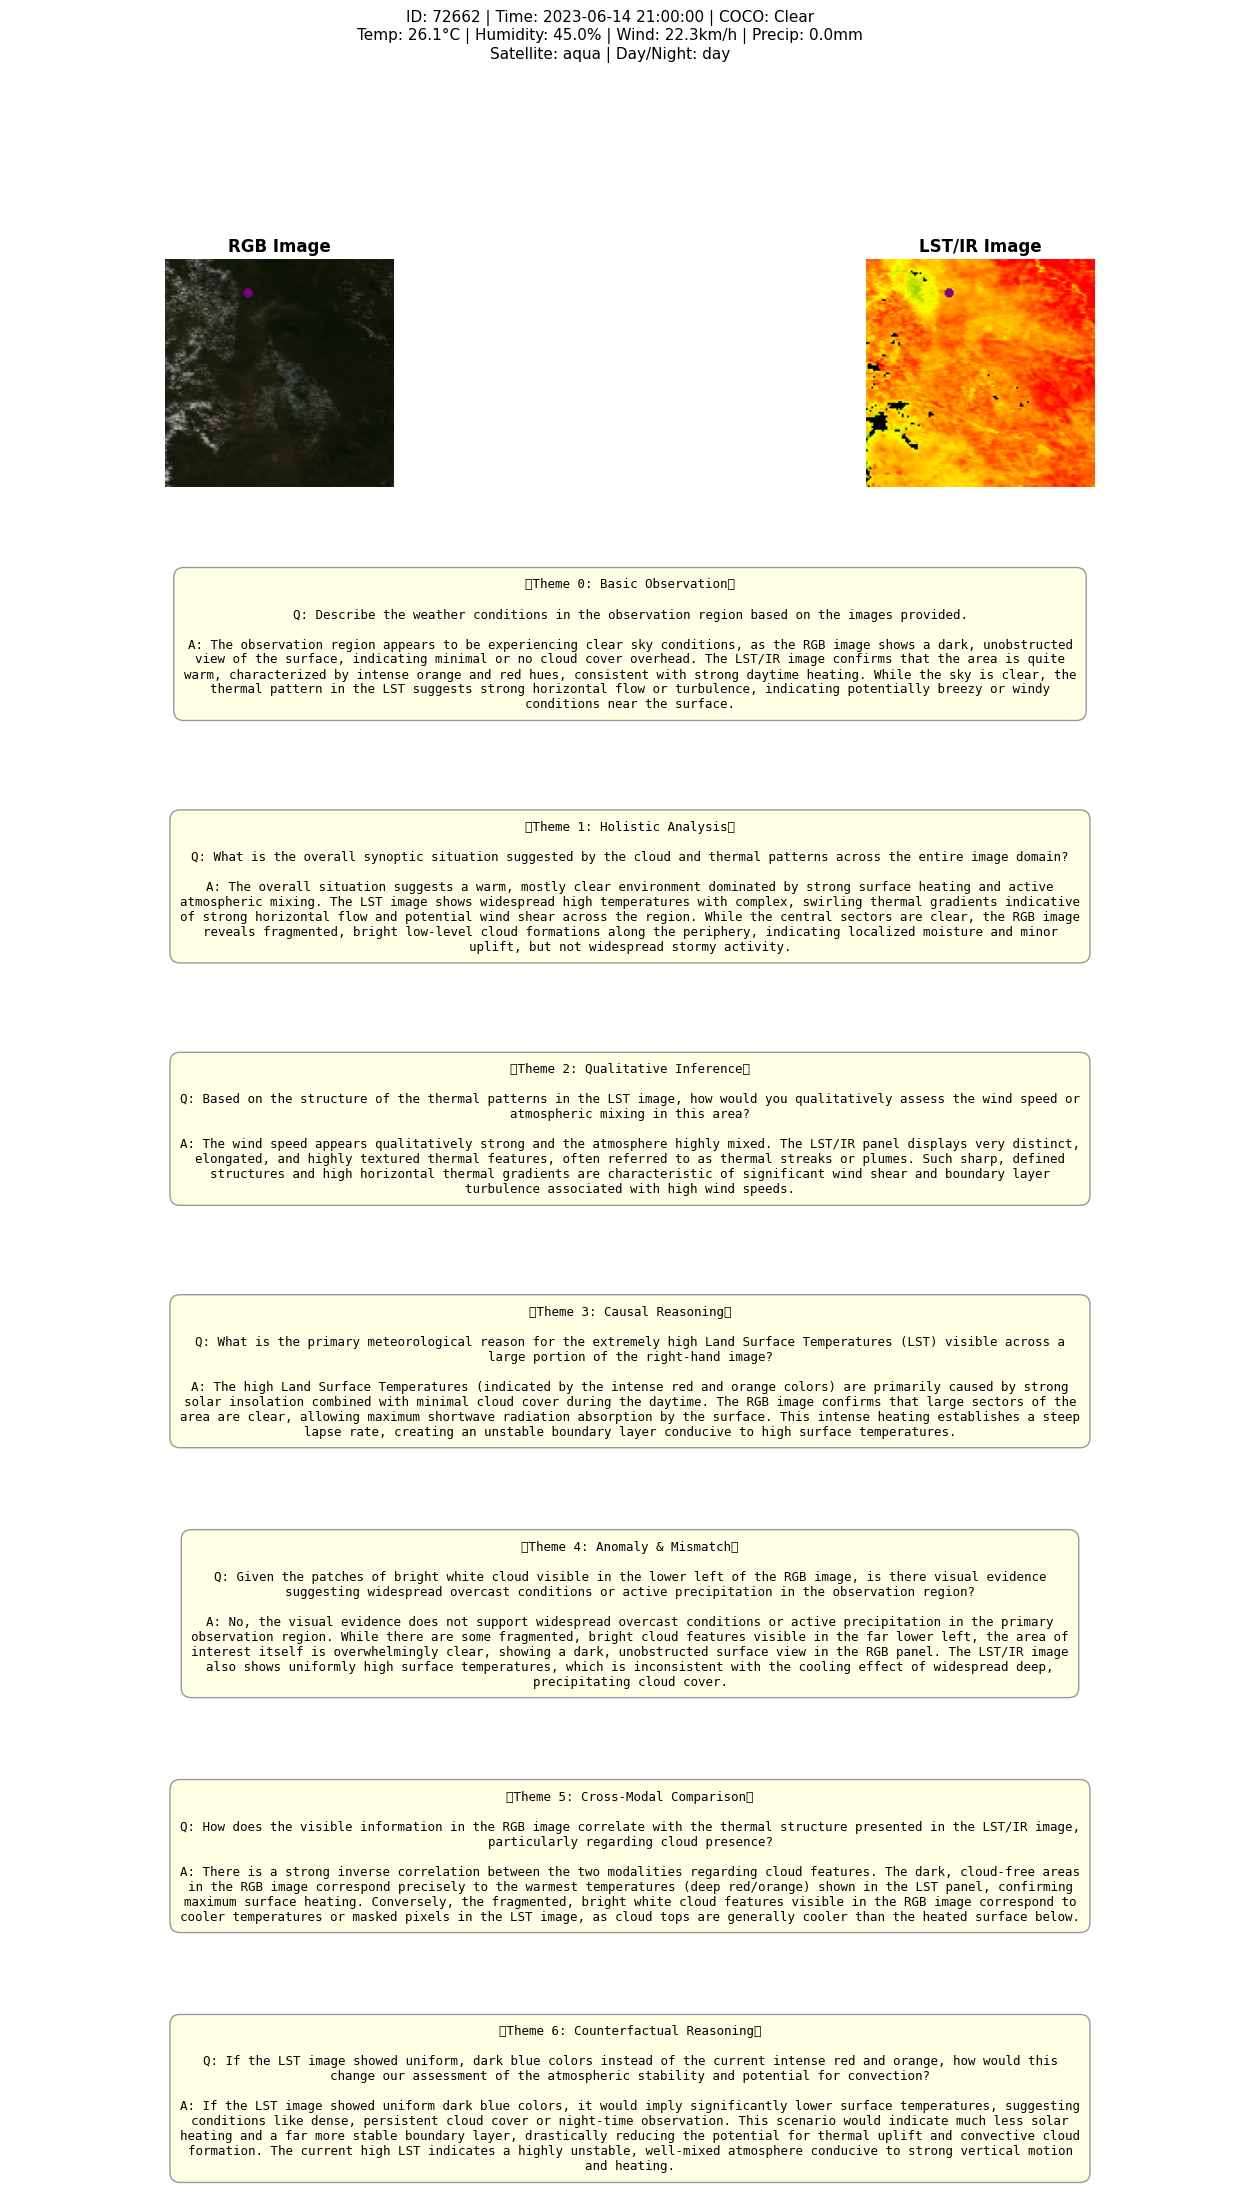

In [10]:
import json
import random
import matplotlib.pyplot as plt
from matplotlib import patches
import textwrap

def visualize_random_sample(jsonl_path='generated_weather_dataset_gemini.jsonl', rgb_dir='./rgb/', ir_dir='./ir/'):
    """
    JSONL 파일에서 랜덤으로 샘플을 선택하고 RGB/IR 이미지와 생성된 Q&A를 시각화합니다.
    """
    # 1. JSONL 파일 읽기
    with open(jsonl_path, 'r', encoding='utf-8') as f:
        samples = [json.loads(line) for line in f if line.strip()]
    
    if not samples:
        print("JSONL 파일에 샘플이 없습니다.")
        return
    
    # 2. 랜덤 샘플 선택
    pick = None
    # pick = "98538_aqua_day_coco9_23093005_lh13_10.286353_120.964097_19.511578_130.510257.png"
    if not pick:
        sample = random.choice(samples)
    else:
        sample = next((s for s in samples if s.get('source_filename') == pick), None)
        if sample is None:
            print(f"지정한 파일명을 찾을 수 없습니다: {pick}")
            return
    
    sample_id = sample.get('sample_id', 'N/A')
    filename = sample.get('source_filename', 'N/A')
    labels = sample.get('ground_truth_labels', {})
    qas = sample.get('generated_qas', [])
    
    # 3. 이미지 로드
    # filename에서 ID, COCO, UTC 시간 추출
    parsed = parse_filename_for_matching(filename)
    if not parsed:
        print(f"파일명 파싱 실패: {filename}")
        return
    
    id_prefix = parsed['id']
    coco_str = str(parsed['coco'])
    utc_datetime_str = parsed['utc_datetime_str']
    
    rgb_path = find_file(rgb_dir, id_prefix, coco_str, utc_datetime_str)
    ir_path = find_file(ir_dir, id_prefix, coco_str, utc_datetime_str)
    
    if not rgb_path or not ir_path:
        print(f"이미지를 찾을 수 없습니다: RGB={rgb_path}, IR={ir_path}")
        return
    
    rgb_img = Image.open(rgb_path)
    ir_img = Image.open(ir_path)
    
    # 파일명에서 추가 메타데이터 파싱 (bbox 정보 포함)
    full_metadata = parse_full_filename_metadata(filename)
    # labels와 병합
    merged_metadata = {**labels, **full_metadata}
    
    # 점 위치 계산
    pixel_x, pixel_y, can_plot_dot = calculate_dot_position(merged_metadata)
    
    # 이미지에 보라색 점 그리기
    if can_plot_dot:
        try:
            # RGB 이미지에 점 그리기
            rgb_img = rgb_img.convert("RGB")
            draw_rgb = ImageDraw.Draw(rgb_img)
            draw_rgb.ellipse((pixel_x - 2, pixel_y - 2, pixel_x + 2, pixel_y + 2), fill='purple', outline='purple')
            
            # IR 이미지에 점 그리기
            ir_img = ir_img.convert("RGB")
            draw_ir = ImageDraw.Draw(ir_img)
            draw_ir.ellipse((pixel_x - 2, pixel_y - 2, pixel_x + 2, pixel_y + 2), fill='purple', outline='purple')
        except Exception as e:
            print(f"Warning: 이미지에 점을 그리는 중 오류: {e}")
    
    # 4. 시각화
    num_qas = len(qas)
    fig = plt.figure(figsize=(16, 4 + num_qas * 3))
    
    # 그리드 생성: 상단에 이미지 2개, 하단에 Q&A들
    gs = fig.add_gridspec(num_qas + 1, 2, height_ratios=[2] + [1.5] * num_qas, hspace=0.4, wspace=0.3)
    
    # 메타데이터 정보
    coco_val = labels.get('coco', 'N/A')
    coco_text = COCO_MAP.get(coco_val, f"Unknown Class ({coco_val})")
    
    weather_info = (
        f"ID: {sample_id} | Time: {labels.get('time', 'N/A')} | COCO: {coco_text}\n"
        f"Temp: {labels.get('temp', 'N/A')}°C | Humidity: {labels.get('rhum', 'N/A')}% | "
        f"Wind: {labels.get('wspd', 'N/A')}km/h | Precip: {labels.get('prcp', 'N/A')}mm\n"
        f"Satellite: {labels.get('satellite', 'N/A')} | Day/Night: {labels.get('day_night', 'N/A')}"
    )
    
    fig.suptitle(weather_info, fontsize=11, y=0.98, ha='center')
    
    # RGB 이미지
    ax_rgb = fig.add_subplot(gs[0, 0])
    ax_rgb.imshow(rgb_img)
    ax_rgb.set_title("RGB Image", fontsize=12, fontweight='bold')
    ax_rgb.axis('off')
    
    # IR 이미지
    ax_ir = fig.add_subplot(gs[0, 1])
    ax_ir.imshow(ir_img)
    ax_ir.set_title("LST/IR Image", fontsize=12, fontweight='bold')
    ax_ir.axis('off')
    
    # Q&A 표시
    for idx, qa in enumerate(qas):
        ax_qa = fig.add_subplot(gs[idx + 1, :])
        ax_qa.axis('off')
        
        theme = qa.get('theme', 'Unknown Theme')
        question = qa.get('question', 'N/A')
        answer = qa.get('answer', 'N/A')
        
        # 텍스트 래핑
        wrapped_q = textwrap.fill(f"Q: {question}", width=120)
        wrapped_a = textwrap.fill(f"A: {answer}", width=120)
        
        text_content = f"【{theme}】\n\n{wrapped_q}\n\n{wrapped_a}"
        
        # 박스 스타일
        box_props = dict(boxstyle='round,pad=0.8', facecolor='lightyellow', edgecolor='gray', alpha=0.8)
        ax_qa.text(0.5, 0.5, text_content, transform=ax_qa.transAxes,
                   fontsize=9, verticalalignment='center', horizontalalignment='center',
                   bbox=box_props, family='monospace')
    
    plt.tight_layout()
    plt.show()

# 실행
visualize_random_sample()